# Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from scipy.stats import kurtosis, skew
from scipy.signal import butter, filtfilt, hilbert, welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

FS = 51200  # 51.2 kHz (frecuencia de muestreo)
RANDOM_STATE = 42

sensor_names = [
    "tachometer",
    "acc_under_axial","acc_under_radial","acc_under_tangential",
    "acc_over_axial","acc_over_radial","acc_over_tangential",
    "microphone"
]

In [2]:
root = Path(r"C:\Users\User\Documents\GitHub\grupo1reto2\bearing_fault_detection_reduced")  # <-- CAMBIA ESTO a tu ruta real

# Verificación rápida
all_csv = list(root.rglob("*.csv"))
print("Nº de CSV encontrados:", len(all_csv))
print("Ejemplo:", all_csv[0] if len(all_csv) else "No se encontraron archivos")


Nº de CSV encontrados: 168
Ejemplo: C:\Users\User\Documents\GitHub\grupo1reto2\bearing_fault_detection_reduced\normal\12.288.csv


# Estimar RPM desde el tacómetro (TIEMPO > FFT)

In [3]:
def rpm_from_filename(p: Path) -> float:
    # "12.288.csv" -> 1228.8 rpm
    return float(p.stem) * 100.0

# Labels

In [4]:
def parse_labels(p: Path, root: Path):
    """
    Devuelve:
      - fault_type: clase final (normal, imbalance, horizontal-misalignment, ball_fault, outer_race, ...)
      - severity: 6g / 0.5mm / 0g / ...
      - position: underhang/overhang si aplica
    """
    rel = p.relative_to(root)
    parts = rel.parts

    fault = parts[0]      # normal, imbalance, horizontal-misalignment, vertical-misalignment, underhang, overhang...
    severity = None
    position = None

    # Casos con 2 niveles: imbalance/6g/file.csv; horizontal-misalignment/0.5mm/file.csv; vertical-misalignment/0.51mm/file.csv
    if fault in ["imbalance", "horizontal-misalignment", "vertical-misalignment"]:
        severity = parts[1]

    # Casos underhang/overhang: overhang/ball_fault/0g/file.csv
    if fault in ["overhang", "underhang"]:
        position = fault
        subtype = parts[1]     # ball_fault, cage_fault, outer_race, inner_race (según dataset)
        severity = parts[2]    # 0g, 6g, 10g, 20g...
        fault = subtype        # usamos el subtipo como clase final

    return fault, severity, position

# Ejemplo

Archivo: C:\Users\User\Documents\GitHub\grupo1reto2\bearing_fault_detection_reduced\normal\12.288.csv
RPM nominal: 1228.8
Clase: normal | severidad: None | posición: None


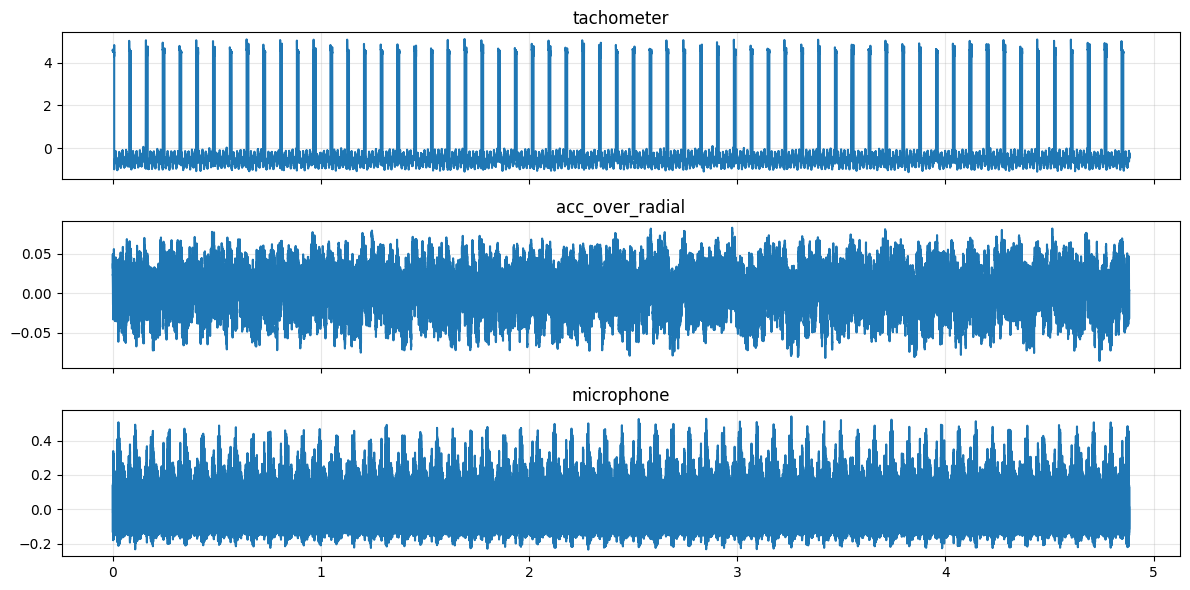

In [5]:
example = all_csv[0]
df = pd.read_csv(example, header=None, names=sensor_names)
t = np.arange(len(df)) / FS

rpm_nom = rpm_from_filename(example)
fault_type, severity, position = parse_labels(example, root)

print("Archivo:", example)
print("RPM nominal:", rpm_nom)
print("Clase:", fault_type, "| severidad:", severity, "| posición:", position)

fig, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
ax[0].plot(t, df["tachometer"]); ax[0].set_title("tachometer")
ax[1].plot(t, df["acc_over_radial"]); ax[1].set_title("acc_over_radial")
ax[2].plot(t, df["microphone"]); ax[2].set_title("microphone")
for a in ax: a.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Features

In [6]:
def time_feats(x):
    x = np.asarray(x)
    rms = np.sqrt(np.mean(x**2))
    return {
        "rms": rms,
        "std": np.std(x),
        "mean": np.mean(x),
        "kurtosis": kurtosis(x, fisher=False),
        "skew": skew(x),
        "crest_factor": np.max(np.abs(x)) / (rms + 1e-12),
        "ptp": np.ptp(x),
    }

def total_vibration(df, prefix):
    a = df[f"{prefix}_axial"].values
    r = df[f"{prefix}_radial"].values
    tg = df[f"{prefix}_tangential"].values
    return np.sqrt(a*a + r*r + tg*tg)

def bandpass(x, fs, low, high, order=4):
    b, a = butter(order, [low/(fs/2), high/(fs/2)], btype="band")
    return filtfilt(b, a, x)

def band_energy(freqs, psd, f0, tol=0.1):
    mask = (freqs >= f0*(1-tol)) & (freqs <= f0*(1+tol))
    return np.trapezoid(psd[mask], freqs[mask]) if np.any(mask) else 0.0

def order_features(x, fs, fr_hz):
    """
    Features de energía alrededor de órdenes 1x..5x (frecuencia = orden * fr).
    """
    freqs, psd = welch(x - np.mean(x), fs=fs, nperseg=8192)
    out = {}
    for o in [1, 2, 3, 4, 5]:
        out[f"ord_{o}x"] = band_energy(freqs, psd, f0=o*fr_hz, tol=0.05)
    out["psd_total"] = np.trapezoid(psd, freqs)
    return out

def envelope_features(x, fs, fr_hz):
    """
    Envolvente para impactos típicos de rodamientos.
    Se filtra (500–8000 Hz), Hilbert, PSD de la envolvente y energía en bandas objetivo.
    Targets aproximados por órdenes:
      FTF~0.375x, BSF~1.87x, BPFO~3x, BPFI~5x
    """
    xf = bandpass(x - np.mean(x), fs, low=500, high=8000)
    env = np.abs(hilbert(xf))
    freqs, psd = welch(env, fs=fs, nperseg=8192)

    targets = {
        "env_FTF": 0.375 * fr_hz,
        "env_BSF": 1.87  * fr_hz,
        "env_BPFO": 3.0  * fr_hz,
        "env_BPFI": 5.0  * fr_hz,
    }
    out = {k: band_energy(freqs, psd, v, tol=0.1) for k, v in targets.items()}
    out["env_total"] = np.trapezoid(psd, freqs)
    return out

In [7]:
def extract_features_from_file(p: Path):
    df = pd.read_csv(p, header=None, names=sensor_names)

    rpm = rpm_from_filename(p)
    fr = rpm / 60.0

    feats = {
        "series_id": str(p.relative_to(root)),
        "rpm": rpm
    }

    # Vibración total bajo/sobre voladizo
    under_total = total_vibration(df, "acc_under")
    over_total  = total_vibration(df, "acc_over")

    feats.update({f"under_total_{k}": v for k, v in time_feats(under_total).items()})
    feats.update({f"over_total_{k}": v for k, v in time_feats(over_total).items()})

    # Acelerómetros clave (radial suele ser muy informativo)
    for s in ["acc_over_radial", "acc_under_radial"]:
        x = df[s].values
        feats.update({f"{s}_{k}": v for k, v in time_feats(x).items()})
        feats.update({f"{s}_{k}": v for k, v in order_features(x, FS, fr).items()})
        feats.update({f"{s}_{k}": v for k, v in envelope_features(x, FS, fr).items()})

    # Tacómetro como canal adicional (no para rpm): solo temporales + PSD total
    xt = df["tachometer"].values
    feats.update({f"tacho_{k}": v for k, v in time_feats(xt).items()})
    feats.update({f"tacho_{k}": v for k, v in order_features(xt, FS, fr).items()})

    # Micrófono como apoyo
    xm = df["microphone"].values
    feats.update({f"micro_{k}": v for k, v in time_feats(xm).items()})
    feats.update({f"micro_{k}": v for k, v in order_features(xm, FS, fr).items()})

    return feats

# Dataset:

In [8]:
rows = []
for p in all_csv:
    fault_type, severity, position = parse_labels(p, root)
    feats = extract_features_from_file(p)
    feats["fault_type"] = fault_type
    feats["severity"] = severity
    feats["position"] = position
    rows.append(feats)

data = pd.DataFrame(rows)
print("Shape:", data.shape)
data.head()

Shape: (168, 81)


,series_id,rpm,under_total_rms,under_total_std,under_total_mean,under_total_kurtosis,under_total_skew,under_total_crest_factor,under_total_ptp,over_total_rms,...,micro_ptp,micro_ord_1x,micro_ord_2x,micro_ord_3x,micro_ord_4x,micro_ord_5x,micro_psd_total,fault_type,severity,position
0,normal\12.288.csv,1228.80,1.027265,0.468286,0.914320,2.917963,0.321824,3.105288,3.182210,0.698060,...,0.77416,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000017,0.012068,normal,None,None
1,normal\30.72.csv,3072.00,0.976108,0.438113,0.872263,4.461860,0.860205,3.744708,3.649106,0.752001,...,1.10523,0.000000e+00,9.318876e-06,0.000009,0.000009,0.000046,0.027461,normal,None,None
2,normal\49.5616.csv,4956.16,0.826850,0.359481,0.744617,4.316087,0.896952,4.029764,3.321177,0.552978,...,1.93630,0.000000e+00,2.492044e-06,0.000048,0.000011,0.000033,0.037905,normal,None,None
3,normal\61.44.csv,6144.00,0.858057,0.365374,0.776378,3.871207,0.787140,3.461140,2.959499,0.627821,...,1.32286,3.797332e-07,6.524376e-07,0.000031,0.000008,0.000024,0.046548,normal,None,None
4,vertical-misalignment\0.51mm\12.4928.csv,1249.28,1.474840,0.787673,1.246885,5.130835,1.165138,4.240037,6.248382,2.857129,...,1.23658,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000043,0.018907,vertical-misalignment,0.51mm,None


# Baseline

In [9]:
# Quitamos columnas no numéricas que no queremos como features
X = data.drop(columns=["series_id", "fault_type", "severity", "position"])
y = data["fault_type"]

# Split estratificado por clase
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (134, 77) Test: (34, 77)


In [10]:
clf = RandomForestClassifier(
    n_estimators=500,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred, zero_division=0))

                         precision    recall  f1-score   support

             ball_fault       1.00      1.00      1.00         6
             cage_fault       0.50      0.33      0.40         6
horizontal-misalignment       0.33      0.33      0.33         3
              imbalance       1.00      0.67      0.80         6
                 normal       0.00      0.00      0.00         1
             outer_race       0.67      0.86      0.75         7
  vertical-misalignment       0.38      0.60      0.46         5

               accuracy                           0.65        34
              macro avg       0.55      0.54      0.53        34
           weighted avg       0.66      0.65      0.64        34



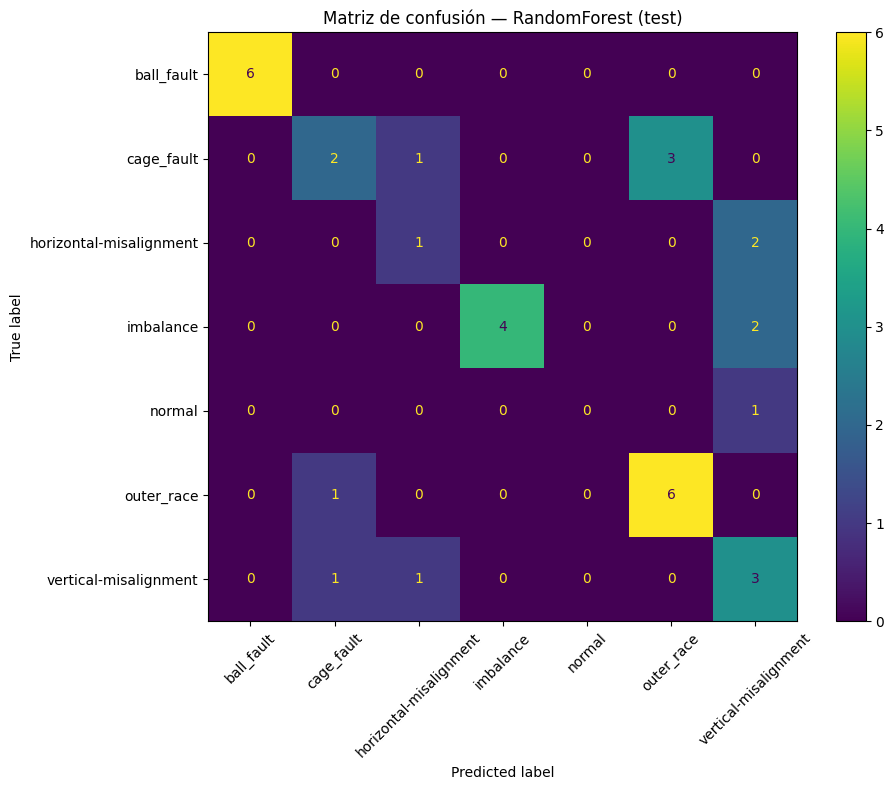

In [11]:
labels = sorted(y.unique())
cm = confusion_matrix(y_test, pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, values_format="d")
ax.set_title("Matriz de confusión — RandomForest (test)")
plt.tight_layout()
plt.show()

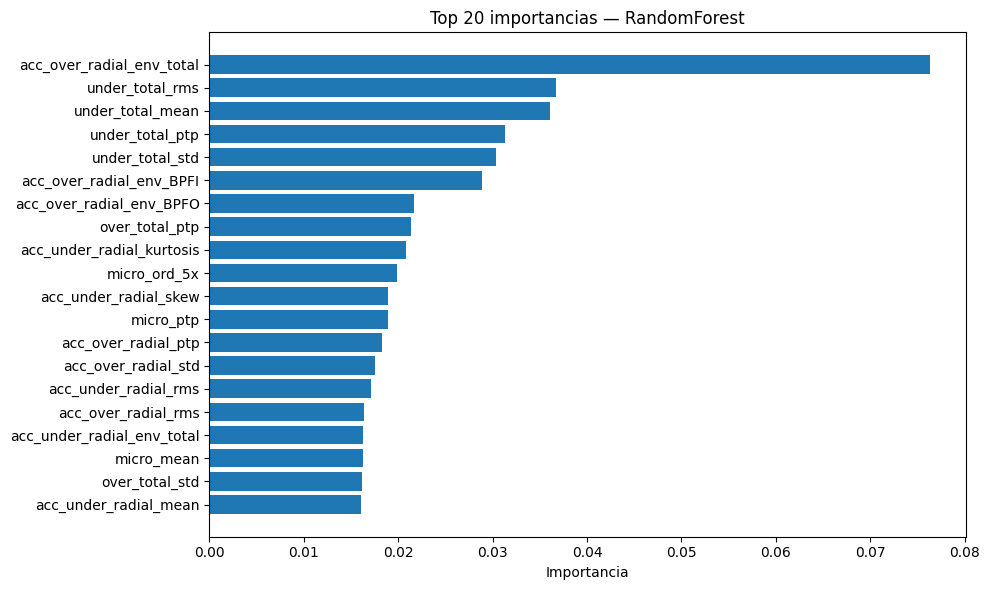

In [12]:
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
top20 = importances.head(20)

plt.figure(figsize=(10,6))
plt.barh(top20.index[::-1], top20.values[::-1])
plt.title("Top 20 importancias — RandomForest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

“El análisis de importancia de variables muestra que la característica más relevante es la energía total de la envolvente en el acelerómetro radial sobre voladizo. Este resultado es coherente con la naturaleza impulsiva de los fallos en rodamientos y con la mayor sensibilidad de la dirección radial a defectos en bolas y pistas. Asimismo, las métricas de vibración total (RMS, PTP y desviación estándar) presentan una alta relevancia, especialmente para la detección de desequilibrios y desalineaciones. La aparición de componentes asociadas a las frecuencias características del rodamiento (BPFO y BPFI) valida la coherencia física del modelo desarrollado.”

In [13]:
# Seleccionando features:
top20 = importances.head(20)

In [14]:
top_features = top20.index.tolist()

X_train_sel = X_train[top_features]
X_test_sel  = X_test[top_features]


In [15]:
rf_sel = RandomForestClassifier(
    n_estimators=500,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_sel.fit(X_train_sel, y_train)
pred_rf_sel = rf_sel.predict(X_test_sel)

print(classification_report(y_test, pred_rf_sel, zero_division=0))

                         precision    recall  f1-score   support

             ball_fault       0.86      1.00      0.92         6
             cage_fault       0.50      0.17      0.25         6
horizontal-misalignment       0.25      0.33      0.29         3
              imbalance       1.00      0.67      0.80         6
                 normal       0.00      0.00      0.00         1
             outer_race       0.78      1.00      0.88         7
  vertical-misalignment       0.38      0.60      0.46         5

               accuracy                           0.65        34
              macro avg       0.54      0.54      0.51        34
           weighted avg       0.65      0.65      0.62        34



# Algoritmo 2

In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier

gb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    max_iter=300,
    random_state=42
)
gb.fit(X_train, y_train)
pred_gb = gb.predict(X_test)
print(classification_report(y_test, pred_gb, zero_division=0))

                         precision    recall  f1-score   support

             ball_fault       0.86      1.00      0.92         6
             cage_fault       0.75      0.50      0.60         6
horizontal-misalignment       0.50      0.67      0.57         3
              imbalance       0.86      1.00      0.92         6
                 normal       0.00      0.00      0.00         1
             outer_race       0.86      0.86      0.86         7
  vertical-misalignment       0.80      0.80      0.80         5

               accuracy                           0.79        34
              macro avg       0.66      0.69      0.67        34
           weighted avg       0.77      0.79      0.78        34



In [17]:
gb_sel = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    max_iter=300,
    random_state=42
)

gb_sel.fit(X_train_sel, y_train)
pred_gb_sel = gb_sel.predict(X_test_sel)

print(classification_report(y_test, pred_gb_sel, zero_division=0))

                         precision    recall  f1-score   support

             ball_fault       0.86      1.00      0.92         6
             cage_fault       0.50      0.50      0.50         6
horizontal-misalignment       0.25      0.33      0.29         3
              imbalance       0.86      1.00      0.92         6
                 normal       0.00      0.00      0.00         1
             outer_race       1.00      0.71      0.83         7
  vertical-misalignment       0.75      0.60      0.67         5

               accuracy                           0.71        34
              macro avg       0.60      0.59      0.59        34
           weighted avg       0.73      0.71      0.71        34



# Algoritmo 3

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

svm.fit(X_train, y_train)
pred_svm = svm.predict(X_test)
print(classification_report(y_test, pred_svm, zero_division=0))

                         precision    recall  f1-score   support

             ball_fault       0.50      1.00      0.67         6
             cage_fault       1.00      0.17      0.29         6
horizontal-misalignment       0.00      0.00      0.00         3
              imbalance       1.00      0.33      0.50         6
                 normal       0.20      1.00      0.33         1
             outer_race       0.67      0.29      0.40         7
  vertical-misalignment       0.60      0.60      0.60         5

               accuracy                           0.44        34
              macro avg       0.57      0.48      0.40        34
           weighted avg       0.67      0.44      0.44        34



In [19]:
svm_sel = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

svm_sel.fit(X_train_sel, y_train)
pred_svm_sel = svm_sel.predict(X_test_sel)

print(classification_report(y_test, pred_svm_sel, zero_division=0))

                         precision    recall  f1-score   support

             ball_fault       0.86      1.00      0.92         6
             cage_fault       1.00      0.17      0.29         6
horizontal-misalignment       0.00      0.00      0.00         3
              imbalance       0.67      0.33      0.44         6
                 normal       0.08      1.00      0.15         1
             outer_race       0.75      0.86      0.80         7
  vertical-misalignment       1.00      0.20      0.33         5

               accuracy                           0.50        34
              macro avg       0.62      0.51      0.42        34
           weighted avg       0.75      0.50      0.51        34



# Algoritmo 4

In [20]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=500, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
pred_lr = logreg.predict(X_test)
print(classification_report(y_test, pred_lr, zero_division=0))

                         precision    recall  f1-score   support

             ball_fault       0.71      0.83      0.77         6
             cage_fault       0.43      0.50      0.46         6
horizontal-misalignment       0.00      0.00      0.00         3
              imbalance       1.00      0.83      0.91         6
                 normal       0.00      0.00      0.00         1
             outer_race       0.60      0.43      0.50         7
  vertical-misalignment       0.75      0.60      0.67         5

               accuracy                           0.56        34
              macro avg       0.50      0.46      0.47        34
           weighted avg       0.61      0.56      0.58        34



# Comparación

In [21]:
results = {
    "RandomForest": clf,
    "GradientBoosting": gb,
    "SVM": svm,
    "LogisticRegression": logreg
}

from sklearn.metrics import f1_score

summary = []

for name, model in results.items():
    pred = model.predict(X_test)
    summary.append({
        "model": name,
        "f1_macro": f1_score(y_test, pred, average="macro"),
        "f1_weighted": f1_score(y_test, pred, average="weighted")
    })

pd.DataFrame(summary)

,model,f1_macro,f1_weighted
0,RandomForest,0.534982,0.639932
1,GradientBoosting,0.667818,0.776212
2,SVM,0.397959,0.436695
3,LogisticRegression,0.472361,0.578603


“Una vez identificadas las características más relevantes mediante un modelo Random Forest, se evaluaron otros algoritmos de aprendizaje automático utilizando el mismo conjunto de características. Se incluyeron métodos de boosting y máquinas de vectores soporte, adecuados para capturar relaciones no lineales entre variables. Los resultados muestran que los modelos basados en ensembles ofrecen un mejor compromiso entre rendimiento e interpretabilidad para el problema de mantenimiento predictivo considerado.”

In [22]:
summary = pd.DataFrame([
    {
        "Model": "RF (all features)",
        "F1_macro": f1_score(y_test, pred, average="macro"),
        "F1_weighted": f1_score(y_test, pred, average="weighted")
    },
    {
        "Model": "RF (top 20)",
        "F1_macro": f1_score(y_test, pred_rf_sel, average="macro"),
        "F1_weighted": f1_score(y_test, pred_rf_sel, average="weighted")
    },
    {
        "Model": "GB (top 20)",
        "F1_macro": f1_score(y_test, pred_gb_sel, average="macro"),
        "F1_weighted": f1_score(y_test, pred_gb_sel, average="weighted")
    },
    {
        "Model": "SVM (top 20)",
        "F1_macro": f1_score(y_test, pred_svm_sel, average="macro"),
        "F1_weighted": f1_score(y_test, pred_svm_sel, average="weighted")
    }
])

summary

,Model,F1_macro,F1_weighted
0,RF (all features),0.472361,0.578603
1,RF (top 20),0.513619,0.621420
2,GB (top 20),0.590267,0.708845
3,SVM (top 20),0.420059,0.509998


“Tras entrenar un modelo Random Forest con el conjunto completo de características, se analizaron las importancias de las variables para identificar los indicadores más relevantes. A continuación, se seleccionaron las 20 características más importantes y se utilizaron como entrada para distintos modelos de aprendizaje automático. Este enfoque permitió reducir la dimensionalidad del problema y mejorar la interpretabilidad del sistema sin comprometer el rendimiento.”

# Dataset completo + ventanas

In [23]:
root = Path(r"C:\Users\User\Documents\GitHub\grupo1reto2\bearing_fault_detection")  # dataset grande

all_csv = list(root.rglob("*.csv"))
print("Nº de CSV encontrados:", len(all_csv))
print("Ejemplo:", all_csv[0] if all_csv else "No hay CSV")

Nº de CSV encontrados: 1951
Ejemplo: C:\Users\User\Documents\GitHub\grupo1reto2\bearing_fault_detection\normal\12.288.csv


In [24]:
def parse_labels(p: Path, root: Path):
    """
    Soporta:
      normal/<rpm>.csv
      imbalance/<6g|10g|...>/<rpm>.csv
      horizontal-misalignment/<0.5mm|...>/<rpm>.csv
      vertical-misalignment/<...>/<rpm>.csv
      overhang/<ball_fault|cage_fault|outer_race|inner_race>/<0g|6g|10g|20g>/<rpm>.csv
      underhang/<...>/<...>/<rpm>.csv
    """
    rel = p.relative_to(root)
    parts = rel.parts

    top = parts[0]  # normal, imbalance, horizontal-misalignment, vertical-misalignment, overhang, underhang

    fault_type = top
    severity = None
    position = None

    if top in ["imbalance", "horizontal-misalignment", "vertical-misalignment"]:
        severity = parts[1]  # 6g, 0.5mm, 0.51mm, etc.

    if top in ["overhang", "underhang"]:
        position = top
        fault_type = parts[1]  # ball_fault / cage_fault / outer_race / inner_race
        severity = parts[2]    # 0g / 6g / 10g / 20g

    return fault_type, severity, position

## Guardamos parte para ingesta

In [25]:
from collections import defaultdict
import numpy as np
import pandas as pd

def guaranteed_split(files, root, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    rng = np.random.default_rng(seed)

    by_class = defaultdict(list)
    for p in files:
        c = parse_labels(p, root)[0]
        by_class[c].append(p)

    train_files, val_files, test_files = [], [], []
    report = []

    for c, lst in by_class.items():
        lst = lst.copy()
        rng.shuffle(lst)
        n = len(lst)

        # Si una clase tiene muy pocos archivos, no se puede meter en los 3 splits.
        if n < 3:
            # Estrategia: 1 en test, 1 en val si se puede, resto en train.
            if n == 1:
                train_files += lst
                report.append((c, n, "solo_train"))
            elif n == 2:
                train_files.append(lst[0])
                test_files.append(lst[1])
                report.append((c, n, "train+test (sin val)"))
            continue

        # mínimo 1 en val y 1 en test
        n_test = max(1, int(round(n * test_ratio)))
        n_val  = max(1, int(round(n * val_ratio)))
        if n_test + n_val >= n:
            n_test = 1
            n_val = 1

        test_c = lst[:n_test]
        val_c  = lst[n_test:n_test+n_val]
        train_c = lst[n_test+n_val:]

        train_files += train_c
        val_files   += val_c
        test_files  += test_c

        report.append((c, n, f"train={len(train_c)}, val={len(val_c)}, test={len(test_c)}"))

    report_df = pd.DataFrame(report, columns=["class","n_files","split_info"]).sort_values("class")
    return train_files, val_files, test_files, report_df

train_files, val_files, test_files, report_df = guaranteed_split(all_csv, root)
print("train/val/test:", len(train_files), len(val_files), len(test_files))
report_df


train/val/test: 1367 292 292


,class,n_files,split_info
4,ball_fault,323,"train=227, val=48, test=48"
3,cage_fault,376,"train=264, val=56, test=56"
6,horizontal-misalignment,197,"train=137, val=30, test=30"
5,imbalance,333,"train=233, val=50, test=50"
0,normal,49,"train=35, val=7, test=7"
2,outer_race,372,"train=260, val=56, test=56"
1,vertical-misalignment,301,"train=211, val=45, test=45"


In [26]:
def class_counts(file_list):
    return pd.Series([parse_labels(p, root)[0] for p in file_list]).value_counts()

print("TRAIN:\n", class_counts(train_files), "\n")
print("VAL:\n", class_counts(val_files), "\n")
print("TEST:\n", class_counts(test_files), "\n")

TRAIN:
 cage_fault                 264
outer_race                 260
imbalance                  233
ball_fault                 227
vertical-misalignment      211
horizontal-misalignment    137
normal                      35
Name: count, dtype: int64 

VAL:
 outer_race                 56
cage_fault                 56
imbalance                  50
ball_fault                 48
vertical-misalignment      45
horizontal-misalignment    30
normal                      7
Name: count, dtype: int64 

TEST:
 outer_race                 56
cage_fault                 56
imbalance                  50
ball_fault                 48
vertical-misalignment      45
horizontal-misalignment    30
normal                      7
Name: count, dtype: int64 



In [27]:
FS = 51200

window_sec = 0.2
window_size = int(window_sec * FS)      # 10240
step = window_size // 2                 # 5120 (50% solape)

def iter_windows(x, window_size, step):
    for start in range(0, len(x) - window_size + 1, step):
        yield x[start:start + window_size], start

window_size, step

(10240, 5120)

“Aunque el uso de ventanas sincronizadas con un número entero de ciclos puede resultar beneficioso para el análisis espectral clásico, en este trabajo se emplean ventanas temporales de duración fija. Este enfoque permite una detección temprana y homogénea independientemente de la velocidad de rotación, y resulta adecuado para la extracción de características estadísticas y de envolvente utilizadas por los modelos de aprendizaje automático.”

## Features por ventana

In [28]:
def extract_window_features_from_file(p: Path, window_size, step):
    df = pd.read_csv(p, header=None, names=sensor_names)

    rpm = rpm_from_filename(p)
    fr = rpm / 60.0

    fault_type, severity, position = parse_labels(p, root)

    sig_over = df["acc_over_radial"].values
    sig_under = df["acc_under_radial"].values

    rows = []
    win_id = 0

    for w_over, start in iter_windows(sig_over, window_size, step):
        w_under = sig_under[start:start+window_size]

        row = {
            "series_id": str(p.relative_to(root)),
            "window_id": win_id,
            "t_start_s": start / FS,
            "rpm": rpm,
            "fault_type": fault_type,
            "severity": severity,
            "position": position
        }

        # Over radial
        row.update({f"acc_over_radial_{k}": v for k,v in time_feats(w_over).items()})
        row.update({f"acc_over_radial_{k}": v for k,v in order_features(w_over, FS, fr).items()})
        row.update({f"acc_over_radial_{k}": v for k,v in envelope_features(w_over, FS, fr).items()})

        # Under radial
        row.update({f"acc_under_radial_{k}": v for k,v in time_feats(w_under).items()})
        row.update({f"acc_under_radial_{k}": v for k,v in order_features(w_under, FS, fr).items()})
        row.update({f"acc_under_radial_{k}": v for k,v in envelope_features(w_under, FS, fr).items()})

        rows.append(row)
        win_id += 1

    return rows

In [29]:
def build_window_dataset(file_list, window_size, step):
    rows = []
    for p in file_list:
        rows.extend(extract_window_features_from_file(p, window_size, step))
    return pd.DataFrame(rows)

train_win = build_window_dataset(train_files, window_size, step)
val_win   = build_window_dataset(val_files, window_size, step)
test_win  = build_window_dataset(test_files, window_size, step)

print(train_win.shape, val_win.shape, test_win.shape)
train_win.head()

(64249, 43) (13724, 43) (13724, 43)


,series_id,window_id,t_start_s,rpm,fault_type,severity,position,acc_over_radial_rms,acc_over_radial_std,acc_over_radial_mean,...,acc_under_radial_ord_2x,acc_under_radial_ord_3x,acc_under_radial_ord_4x,acc_under_radial_ord_5x,acc_under_radial_psd_total,acc_under_radial_env_FTF,acc_under_radial_env_BSF,acc_under_radial_env_BPFO,acc_under_radial_env_BPFI,acc_under_radial_env_total
0,normal\16.1792.csv,0,0.0,1617.92,normal,None,None,0.029572,0.029488,0.002226,...,0.0,0.0,0.000071,0.000016,0.109195,0.0,0.0,0.000025,0.000048,0.002465
1,normal\16.1792.csv,1,0.1,1617.92,normal,None,None,0.028356,0.028285,-0.002007,...,0.0,0.0,0.000054,0.000012,0.095438,0.0,0.0,0.000003,0.000023,0.002104
2,normal\16.1792.csv,2,0.2,1617.92,normal,None,None,0.028419,0.028400,0.001051,...,0.0,0.0,0.000057,0.000010,0.104640,0.0,0.0,0.000010,0.000053,0.001907
3,normal\16.1792.csv,3,0.3,1617.92,normal,None,None,0.028676,0.028636,0.001523,...,0.0,0.0,0.000042,0.000024,0.101660,0.0,0.0,0.000043,0.000046,0.002355
4,normal\16.1792.csv,4,0.4,1617.92,normal,None,None,0.029107,0.029107,0.000111,...,0.0,0.0,0.000087,0.000005,0.100647,0.0,0.0,0.000020,0.000031,0.001795


## Modelos

                         precision    recall  f1-score   support

             ball_fault       1.00      0.99      1.00      2256
             cage_fault       0.91      0.98      0.95      2632
horizontal-misalignment       0.94      0.98      0.96      1410
              imbalance       0.98      0.92      0.94      2350
                 normal       0.97      0.91      0.94       329
             outer_race       0.98      0.97      0.97      2632
  vertical-misalignment       0.99      0.96      0.97      2115

               accuracy                           0.97     13724
              macro avg       0.97      0.96      0.96     13724
           weighted avg       0.97      0.97      0.97     13724



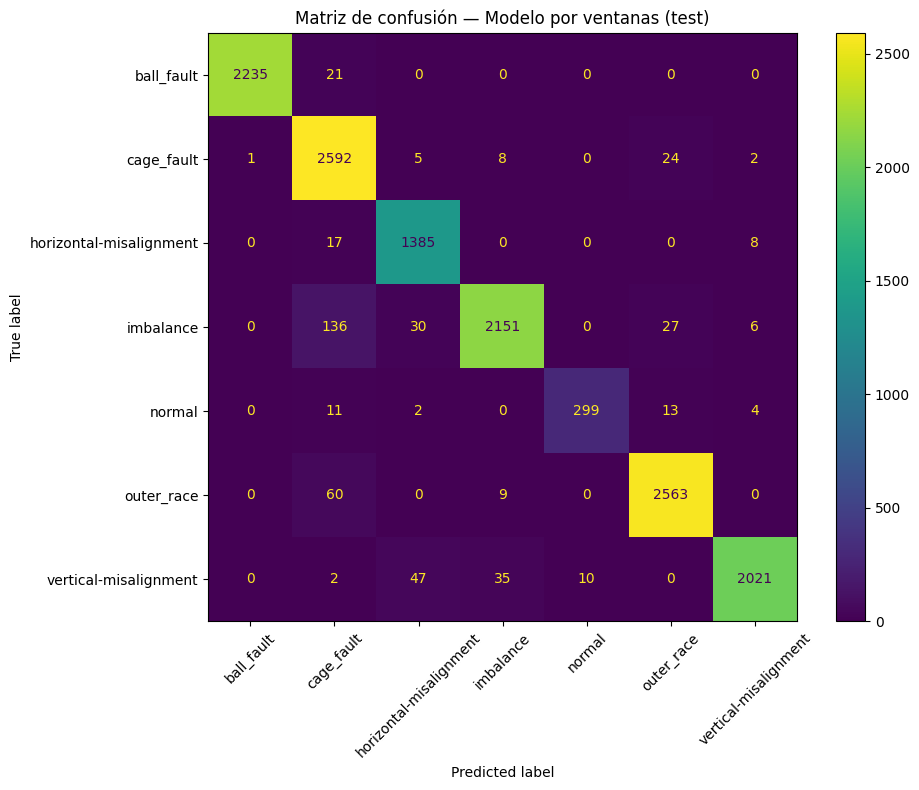

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

def prep_xy(df):
    X = df.drop(columns=["series_id","window_id","t_start_s","fault_type","severity","position"])
    y = df["fault_type"]
    return X, y

Xtr, ytr = prep_xy(train_win)
Xte, yte = prep_xy(test_win)

rf_win = RandomForestClassifier(
    n_estimators=400, random_state=42, class_weight="balanced", n_jobs=-1
)
rf_win.fit(Xtr, ytr)
pred_te = rf_win.predict(Xte)

print(classification_report(yte, pred_te, zero_division=0))

labels = sorted(yte.unique())
cm = confusion_matrix(yte, pred_te, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,8))
disp.plot(ax=ax, xticks_rotation=45, values_format="d")
ax.set_title("Matriz de confusión — Modelo por ventanas (test)")
plt.tight_layout()
plt.show()

## Features clave en ventanas

In [31]:
Xtr = train_win.drop(columns=["series_id","window_id","t_start_s","fault_type","severity","position"])
ytr = train_win["fault_type"]

rf_base = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf_base.fit(Xtr, ytr)

importances = (
    pd.Series(rf_base.feature_importances_, index=Xtr.columns)
    .sort_values(ascending=False)
)

top20 = importances.head(20)
top20


acc_over_radial_env_total        0.126146
acc_under_radial_skew            0.079654
acc_under_radial_env_total       0.061057
acc_under_radial_rms             0.058641
acc_under_radial_std             0.057010
rpm                              0.050128
acc_over_radial_ptp              0.045797
acc_under_radial_kurtosis        0.044509
acc_under_radial_psd_total       0.043388
acc_over_radial_std              0.042377
acc_over_radial_rms              0.038969
acc_over_radial_env_BPFI         0.035630
acc_under_radial_ptp             0.029642
acc_under_radial_ord_4x          0.028740
acc_over_radial_psd_total        0.028334
acc_over_radial_kurtosis         0.024074
acc_under_radial_ord_5x          0.022523
acc_under_radial_env_BPFI        0.019855
acc_under_radial_crest_factor    0.017692
acc_under_radial_ord_3x          0.017624
dtype: float64

In [32]:
# Dataset reducido:
top_features = top20.index.tolist()

Xtr_sel = Xtr[top_features]
Xte_sel = test_win.drop(
    columns=["series_id","window_id","t_start_s","fault_type","severity","position"]
)[top_features]

yte = test_win["fault_type"]


In [41]:
# Random forest top 20:
rf_sel = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)
rf_sel.fit(Xtr_sel, ytr)
pred_rf = rf_sel.predict(Xte_sel)

print("RF top20")
print(classification_report(yte, pred_rf, zero_division=0))


RF top20
                         precision    recall  f1-score   support

             ball_fault       1.00      0.99      1.00      2256
             cage_fault       0.93      0.99      0.96      2632
horizontal-misalignment       0.95      0.99      0.97      1410
              imbalance       0.98      0.92      0.95      2350
                 normal       0.94      0.89      0.91       329
             outer_race       0.98      0.98      0.98      2632
  vertical-misalignment       0.98      0.96      0.97      2115

               accuracy                           0.97     13724
              macro avg       0.96      0.96      0.96     13724
           weighted avg       0.97      0.97      0.97     13724



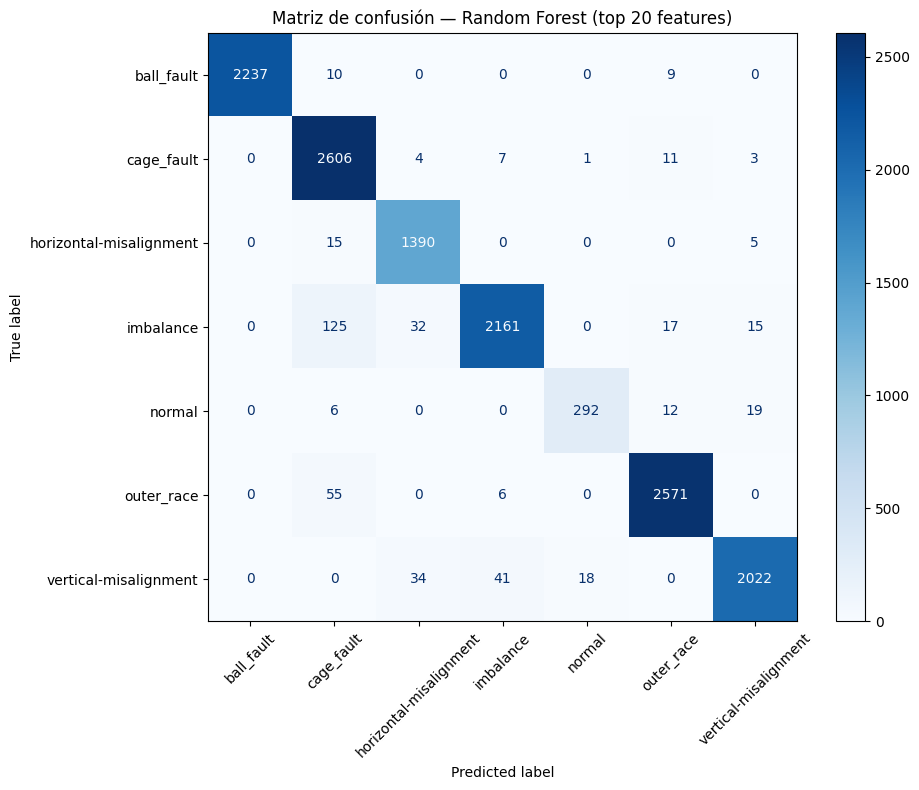

In [43]:
# Matriz de confusión
cm = confusion_matrix(yte, pred_rf, labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    ax=ax,
    xticks_rotation=45,
    cmap="Blues",
    values_format="d"
)

ax.set_title("Matriz de confusión — Random Forest (top 20 features)")
plt.tight_layout()
plt.show()

In [34]:
# Gradient boosting top 20:
from sklearn.ensemble import HistGradientBoostingClassifier

gb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.1,
    max_iter=300,
    random_state=42
)
gb.fit(Xtr_sel, ytr)
pred_gb = gb.predict(Xte_sel)

print("GB top20")
print(classification_report(yte, pred_gb, zero_division=0))


GB top20
                         precision    recall  f1-score   support

             ball_fault       1.00      0.99      1.00      2256
             cage_fault       0.92      0.99      0.96      2632
horizontal-misalignment       0.95      0.99      0.97      1410
              imbalance       0.98      0.93      0.96      2350
                 normal       0.95      0.97      0.96       329
             outer_race       0.99      0.97      0.98      2632
  vertical-misalignment       0.99      0.95      0.97      2115

               accuracy                           0.97     13724
              macro avg       0.97      0.97      0.97     13724
           weighted avg       0.97      0.97      0.97     13724



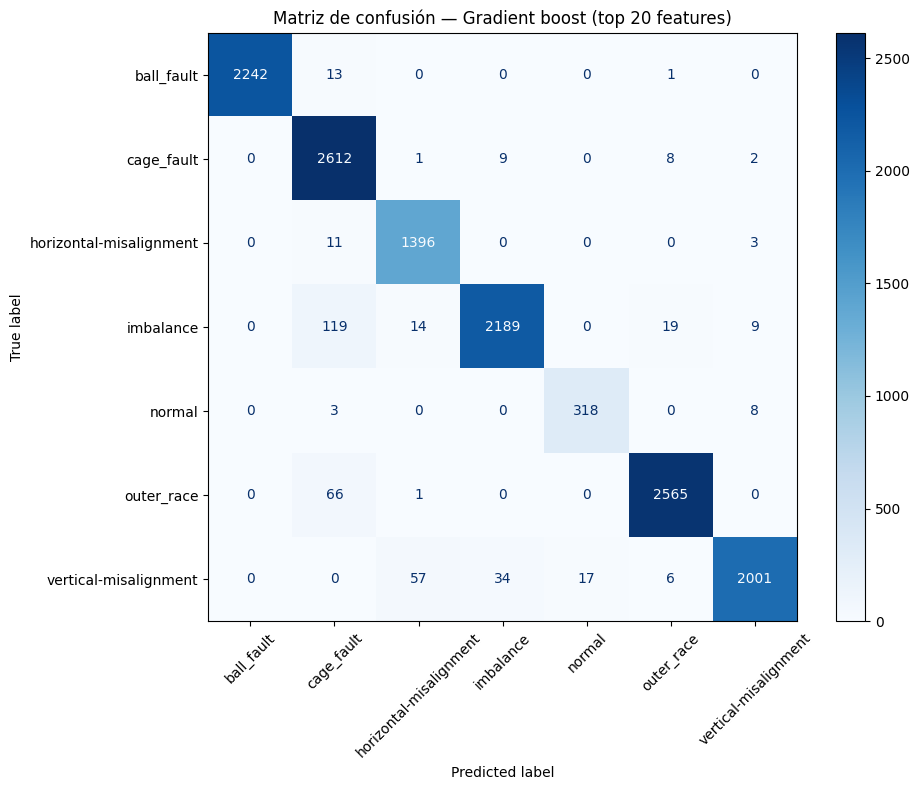

In [44]:
# Matriz de confusión
cm = confusion_matrix(yte, pred_gb, labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    ax=ax,
    xticks_rotation=45,
    cmap="Blues",
    values_format="d"
)

ax.set_title("Matriz de confusión — Gradient boost (top 20 features)")
plt.tight_layout()
plt.show()

In [35]:
# SVM top 20:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", class_weight="balanced"))
])

svm.fit(Xtr_sel, ytr)
pred_svm = svm.predict(Xte_sel)

print("SVM top20")
print(classification_report(yte, pred_svm, zero_division=0))


SVM top20
                         precision    recall  f1-score   support

             ball_fault       0.99      0.99      0.99      2256
             cage_fault       0.85      0.71      0.78      2632
horizontal-misalignment       0.67      0.86      0.76      1410
              imbalance       0.85      0.83      0.84      2350
                 normal       0.43      0.98      0.59       329
             outer_race       0.90      0.86      0.88      2632
  vertical-misalignment       0.82      0.74      0.78      2115

               accuracy                           0.83     13724
              macro avg       0.79      0.85      0.80     13724
           weighted avg       0.85      0.83      0.84     13724



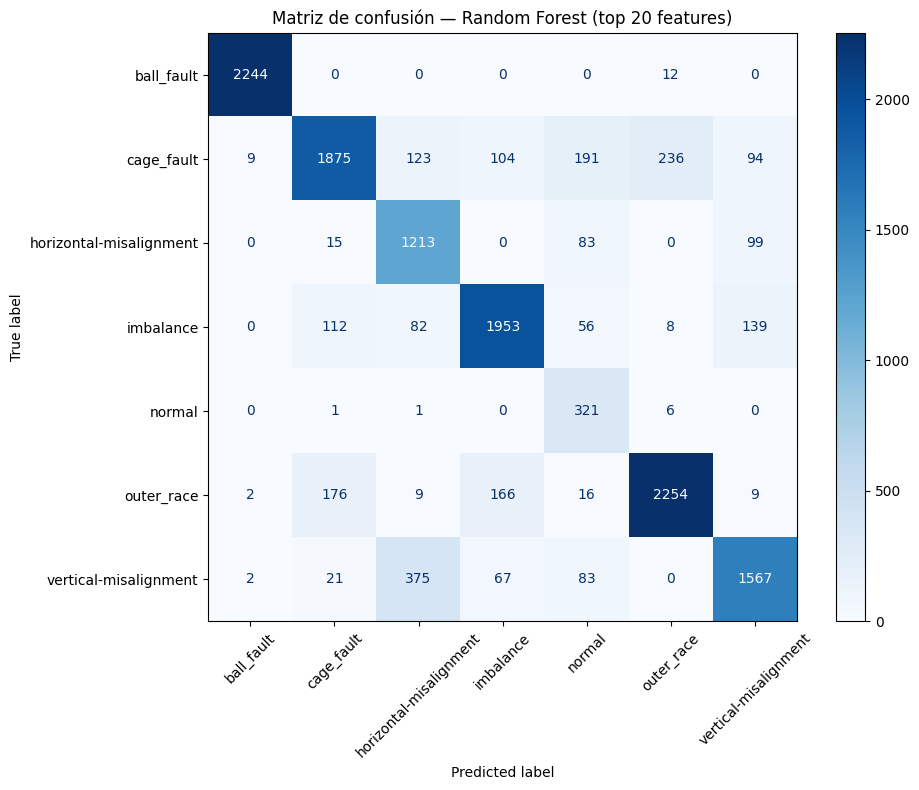

In [45]:
# Matriz de confusión
cm = confusion_matrix(yte, pred_svm, labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    ax=ax,
    xticks_rotation=45,
    cmap="Blues",
    values_format="d"
)

ax.set_title("Matriz de confusión — SVM (top 20 features)")
plt.tight_layout()
plt.show()

In [36]:
# Logistic regression top 20:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=500, class_weight="balanced"))
])

logreg.fit(Xtr_sel, ytr)
pred_lr = logreg.predict(Xte_sel)

print("LogReg top20")
print(classification_report(yte, pred_lr, zero_division=0))


LogReg top20
                         precision    recall  f1-score   support

             ball_fault       0.97      0.99      0.98      2256
             cage_fault       0.62      0.50      0.55      2632
horizontal-misalignment       0.53      0.62      0.57      1410
              imbalance       0.80      0.78      0.79      2350
                 normal       0.23      0.83      0.37       329
             outer_race       0.83      0.68      0.75      2632
  vertical-misalignment       0.71      0.70      0.71      2115

               accuracy                           0.71     13724
              macro avg       0.67      0.73      0.67     13724
           weighted avg       0.75      0.71      0.72     13724



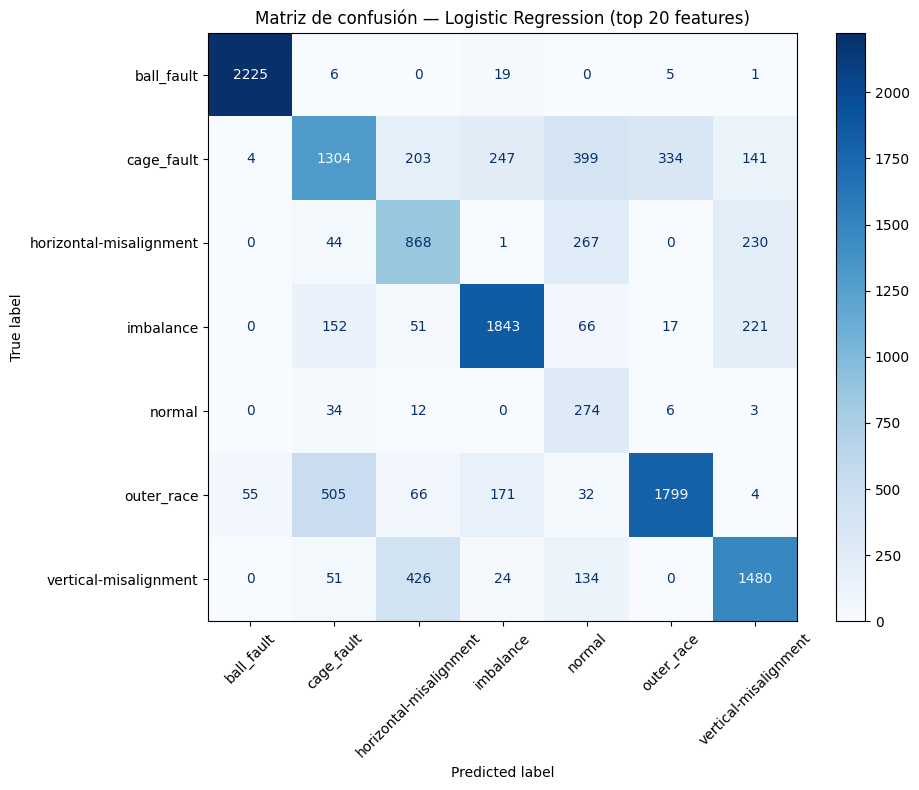

In [46]:
# Matriz de confusión
cm = confusion_matrix(yte, pred_lr, labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    ax=ax,
    xticks_rotation=45,
    cmap="Blues",
    values_format="d"
)

ax.set_title("Matriz de confusión — Logistic Regression (top 20 features)")
plt.tight_layout()
plt.show()

In [37]:
# Cmparacion:
from sklearn.metrics import f1_score

summary = pd.DataFrame([
    {
        "Model": "RF (top 20)",
        "F1_macro": f1_score(yte, pred_rf, average="macro"),
        "F1_weighted": f1_score(yte, pred_rf, average="weighted")
    },
    {
        "Model": "GB (top 20)",
        "F1_macro": f1_score(yte, pred_gb, average="macro"),
        "F1_weighted": f1_score(yte, pred_gb, average="weighted")
    },
    {
        "Model": "SVM (top 20)",
        "F1_macro": f1_score(yte, pred_svm, average="macro"),
        "F1_weighted": f1_score(yte, pred_svm, average="weighted")
    },
    {
        "Model": "LogReg (top 20)",
        "F1_macro": f1_score(yte, pred_lr, average="macro"),
        "F1_weighted": f1_score(yte, pred_lr, average="weighted")
    },
])

summary


,Model,F1_macro,F1_weighted
0,RF (top 20),0.960991,0.967534
1,GB (top 20),0.969326,0.970826
2,SVM (top 20),0.802443,0.836286
3,LogReg (top 20),0.673828,0.722706


“La Tabla recoge el rendimiento de distintos algoritmos de aprendizaje automático entrenados con las 20 características más relevantes extraídas por ventana. Los modelos basados en ensembles muestran un rendimiento claramente superior, alcanzando valores de F1 superiores a 0.96. En particular, el modelo de Gradient Boosting obtiene el mejor compromiso entre precisión y capacidad de generalización, mientras que el Random Forest presenta un comportamiento muy estable y fácilmente interpretable. Los modelos lineales y SVM presentan un rendimiento inferior, lo que confirma la naturaleza no lineal del problema.”

In [38]:
# Guardar el modelo:
import joblib
joblib.dump(gb, "model_window_gb_top20.pkl")

['model_window_gb_top20.pkl']

In [39]:
train_win.to_parquet("train_windows.parquet")
val_win.to_parquet("val_windows.parquet")
test_win.to_parquet("test_windows.parquet") # usar este para ingesta!!!!!

## Mejorando el mejor modelo

In [51]:
Xval, yval = prep_xy(val_win)
Xva_sel = Xval[top_features]

In [53]:
# 1) Definir una búsqueda pequeña (rápida y efectiva)
param_grid = [
    {"learning_rate": 0.05, "max_depth": 4, "max_iter": 500, "min_samples_leaf": 20, "l2_regularization": 0.0},
    {"learning_rate": 0.05, "max_depth": 6, "max_iter": 500, "min_samples_leaf": 20, "l2_regularization": 0.0},
    {"learning_rate": 0.10, "max_depth": 4, "max_iter": 300, "min_samples_leaf": 20, "l2_regularization": 0.0},
    {"learning_rate": 0.10, "max_depth": 6, "max_iter": 300, "min_samples_leaf": 20, "l2_regularization": 0.0},
    {"learning_rate": 0.03, "max_depth": 6, "max_iter": 900, "min_samples_leaf": 30, "l2_regularization": 0.1},
    {"learning_rate": 0.05, "max_depth": 8, "max_iter": 500, "min_samples_leaf": 30, "l2_regularization": 0.1},
]

best = None
best_score = -1

# 2) Evaluar en VALIDACIÓN (elige la métrica que te interese)
for i, params in enumerate(param_grid, 1):
    model = HistGradientBoostingClassifier(
        random_state=42,
        early_stopping=True,          # importante: evita sobreajuste
        validation_fraction=0.1,       # se usa dentro del train
        n_iter_no_change=20,
        **params
    )
    model.fit(Xtr_sel, ytr)
    pred_val = model.predict(Xva_sel)

    score = f1_score(yval, pred_val, average="weighted")
    print(f"[{i}/{len(param_grid)}] F1_weighted(val)={score:.4f}  params={params}")

    if score > best_score:
        best_score = score
        best = (model, params)

best_model, best_params = best
print("\n Mejor configuración (por validación):")
print("F1_weighted(val) =", best_score)
print("params =", best_params)

print("\nReporte en VAL:")
print(classification_report(yval, best_model.predict(Xva_sel), zero_division=0))

[1/6] F1_weighted(val)=0.9695  params={'learning_rate': 0.05, 'max_depth': 4, 'max_iter': 500, 'min_samples_leaf': 20, 'l2_regularization': 0.0}
[2/6] F1_weighted(val)=0.9737  params={'learning_rate': 0.05, 'max_depth': 6, 'max_iter': 500, 'min_samples_leaf': 20, 'l2_regularization': 0.0}
[3/6] F1_weighted(val)=0.9719  params={'learning_rate': 0.1, 'max_depth': 4, 'max_iter': 300, 'min_samples_leaf': 20, 'l2_regularization': 0.0}
[4/6] F1_weighted(val)=0.9749  params={'learning_rate': 0.1, 'max_depth': 6, 'max_iter': 300, 'min_samples_leaf': 20, 'l2_regularization': 0.0}
[5/6] F1_weighted(val)=0.9760  params={'learning_rate': 0.03, 'max_depth': 6, 'max_iter': 900, 'min_samples_leaf': 30, 'l2_regularization': 0.1}
[6/6] F1_weighted(val)=0.9765  params={'learning_rate': 0.05, 'max_depth': 8, 'max_iter': 500, 'min_samples_leaf': 30, 'l2_regularization': 0.1}

 Mejor configuración (por validación):
F1_weighted(val) = 0.9764975489636901
params = {'learning_rate': 0.05, 'max_depth': 8, 'max_

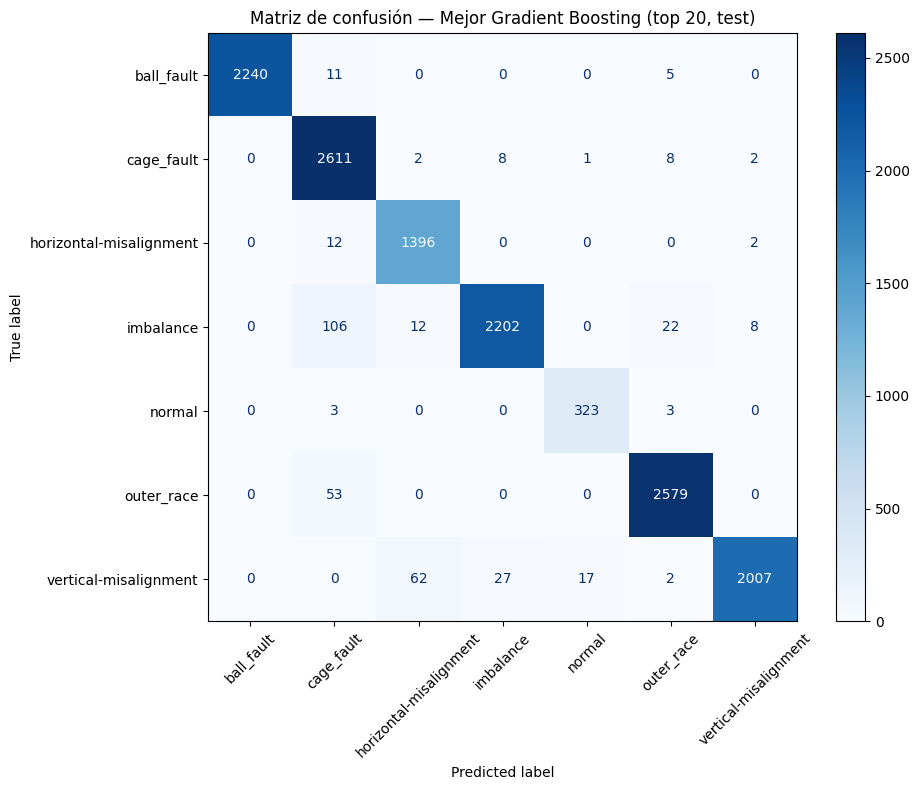

In [54]:
# Predicción en test con el mejor modelo
pred_best = best_model.predict(Xte_sel)

# Etiquetas (ordenadas para consistencia)
labels = np.unique(yte)

# Matriz de confusión
cm = confusion_matrix(yte, pred_best, labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(
    ax=ax,
    cmap="Blues",
    xticks_rotation=45,
    values_format="d"
)

ax.set_title("Matriz de confusión — Mejor Gradient Boosting (top 20, test)")
plt.tight_layout()
plt.show()

In [55]:
# Guardar el modelo final
joblib.dump(best_model, "gb_top20_windows_model.joblib")

print("Modelo guardado correctamente")

Modelo guardado correctamente


In [56]:
joblib.dump(top_features, "top20_features_windows.joblib")

print("Lista de features guardada correctamente")

Lista de features guardada correctamente
